# Double Jet

With various grid sizes

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

# plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [6]:
truth_path = "../scripts/DataAssimilation/DoubleJetTruth/2023-11-02T09_33_29"

true_state = np.load(os.path.join(truth_path, "truth_864000.npy"))

## Ensembles

In [7]:
from utils.DoubleJetSL import *

In [17]:
slda_path = "../scripts/DataAssimilation/DoubleJetSLDA/2023-11-08T21_59_43"

sl_state = np.load(os.path.join(slda_path, "SLstates/SLensemble_864000.npy"))

In [18]:
def ML_from_path(mlda_path): 

    ML_state = []
    ML_state.append(np.load(mlda_path+"/MLstates/MLensemble_0.npy"))

    numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda_path+"/MLstates")]))
    for l_idx in range(1, numLevels):
        ML_state.append( [np.load(mlda_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )

    return ML_state

In [19]:
mlda2_path = "../scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T21_42_15"

ML2_state = ML_from_path(mlda2_path)

In [20]:
ML2_state[0].shape[-1], ML2_state[1][0].shape[-1]

(86, 14)

In [21]:
mlda3_path = "../scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T15_45_28"

ML3_state = ML_from_path(mlda3_path)

ML3_state.append(np.load(mlda3_path+"/MLstates/MLensemble_0.npy"))

numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda3_path+"/MLstates")]))
for l_idx in range(1, numLevels):
    ML3_state.append( [np.load(mlda3_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda3_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )

In [22]:
ML3_state[0].shape[-1], ML3_state[1][0].shape[-1], ML3_state[2][0].shape[-1]

(185, 66, 19)

In [23]:
mlda4_path = "../scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T16_32_29"

ML4_state = ML_from_path(mlda4_path)

In [24]:
ML4_state[0].shape[-1], ML4_state[1][0].shape[-1], ML4_state[2][0].shape[-1], ML4_state[3][0].shape[-1]

(275, 134, 46, 13)

In [25]:
def MLestimator(ML_state, func, **kwargs):
    numLevels = len(ML_state)
    MLest = np.zeros(ML_state[-1][0].shape[:-1])
    MLest += func(ML_state[0], axis=-1, **kwargs).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2)
    for l_idx in range(1, numLevels):
        MLest += (func(ML_state[l_idx][0], axis=-1, **kwargs) - func(ML_state[l_idx][1], axis=-1, **kwargs).repeat(2,1).repeat(2,2)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2)
    return MLest

In [26]:
c0 = (0,0,0)
c3 = (0, 68/255, 136/255)
c2 = (187/255, 85/255, 102/255)
c1 = (221/255, 170/255, 51/255)

In [27]:
Ts = np.arange(0, 13*24*3600, 900)/(24*3600)

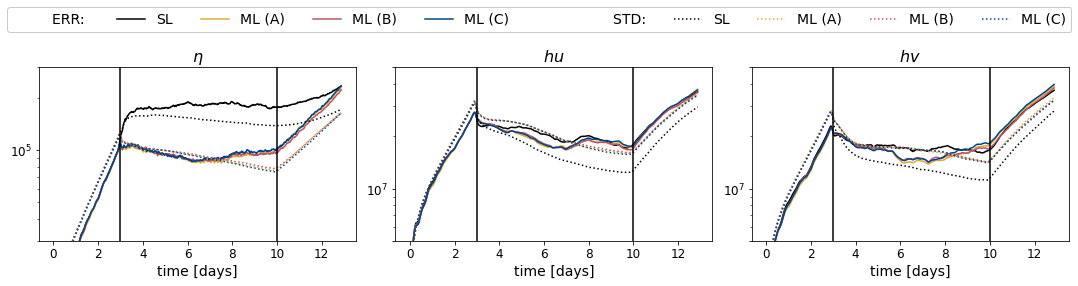

In [29]:
fig, axs = plt.subplots(1,3, figsize=(15,3.5))

sl_rmse  = np.load(slda_path  + "/rmse.npy")
ml2_rmse = np.load(mlda2_path + "/MLrmses_posterior.npy")
ml3_rmse = np.load(mlda3_path + "/MLrmses_posterior.npy")
ml4_rmse = np.load(mlda4_path + "/MLrmses_posterior.npy")

sl_std  = np.load(slda_path  + "/stddev.npy")
ml2_std = np.load(mlda2_path + "/MLstddevs_posterior.npy")
ml3_std = np.load(mlda3_path + "/MLstddevs_posterior.npy")
ml4_std = np.load(mlda4_path + "/MLstddevs_posterior.npy")

for i in range(3):
    axs[i].set_yscale("log")
    # axs[i].plot(Ts, sl_rmse[:,i],  c="red", label="SL")
    # axs[i].plot(Ts, ml2_rmse[:,i], c="C0",  label="ML(2l)")
    # axs[i].plot(Ts, ml3_rmse[:,i], c="C1",  label="ML(3l)")
    # axs[i].plot(Ts, ml4_rmse[:,i], c="C2",  label="ML(4l)")
    N=12
    axs[i].plot(Ts[:-N+1], np.convolve(sl_rmse[:,i] , np.ones(N)/N, mode="valid"), c=c0, label="SL")
    axs[i].plot(Ts[:-N+1], np.convolve(ml2_rmse[:,i], np.ones(N)/N, mode="valid"), c=c1,  label="ML (A)")
    axs[i].plot(Ts[:-N+1], np.convolve(ml3_rmse[:,i], np.ones(N)/N, mode="valid"), c=c2,  label="ML (B)")
    axs[i].plot(Ts[:-N+1], np.convolve(ml4_rmse[:,i], np.ones(N)/N, mode="valid"), c=c3,  label="ML (C)")

    axs[i].plot(Ts[:-N+1], np.convolve(sl_std[:,i] , np.ones(N)/N, mode="valid"), c=c0, ls="dotted", label="SL")
    axs[i].plot(Ts[:-N+1], np.convolve(ml2_std[:,i], np.ones(N)/N, mode="valid"), c=c1, ls="dotted", label="ML (A)")
    axs[i].plot(Ts[:-N+1], np.convolve(ml3_std[:,i], np.ones(N)/N, mode="valid"), c=c2, ls="dotted", label="ML (B)")
    axs[i].plot(Ts[:-N+1], np.convolve(ml4_std[:,i], np.ones(N)/N, mode="valid"), c=c3, ls="dotted", label="ML (C)")

    axs[i].axvline(3, c="black")
    axs[i].axvline(10, c="black")

    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xlabel("time [days]", fontsize=14)
    
    if i == 0:
        axs[i].set_ylim((3e4, 3e5))
        plt.setp(axs[i].get_yminorticklabels(), visible=False)
    else:
        axs[i].set_ylim((5e6, 5e7))
        axs[i].set_yticks([5e6, 1e7, 5e7])
        plt.setp(axs[i].get_yminorticklabels(), visible=False)


# https://stackoverflow.com/questions/44071525/matplotlib-add-titles-to-the-legend-rows
h, l = axs[i].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2

handles = ph[:1] + h[:4] + ph[1:] + h[4:]
labels = ["ERR: "] + l[:4] + ["        STD:"] + l[4:]


leg = fig.legend(handles, labels, loc="upper center", ncol=10, bbox_to_anchor=(0.5, 1.15), framealpha=1.0, fontsize=14)

# for vpack in leg._legend_handle_box.get_children():
#     for hpack in vpack.get_children()[:1]:
#         hpack.get_children()[0].set_width(0)

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

for ax in axs:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()

plt.savefig("DoubleJet-DA-PostProcessing-ERR4paper.pdf", bbox_inches="tight", dpi=300)

In [ ]:
np.amax(sl_rmse[:,2]/ml2_rmse[:,2])

1.2489955082341768

In [ ]:
np.mean(sl_rmse[600:,2]/ml2_rmse[600:,2])

1.039884388962255